# Natural Computing

## Exercises on Evolutionary Computation (Assignment 1)

### Exercise 8

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# input dataset
# X = np.array(['-1.0', '-0.9', '-0.8', '-0.7', '-0.6', '-0.5', '-0.4', '-0.3', '-0.2', '-0.1', 
#               '0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'], dtype=float)

X = [x/10. for x in range(-10,11)] # specifying X like this avoids the math errors for some reason
y = np.array(['0.0000', '-0.1629', '-0.2624', '-0.3129', '-0.3264', '-0.3125', '-0.2784', 
              '-0.2289', '-0.1664', '-0.0909', '0.0', '0.1111', '0.2496', '0.4251', 
              '0.6496', '0.9375', '1.3056', '1.7731', '2.3616', '3.0951', '4.0000'], dtype=float)

data = zip(X, y)

In [3]:
print(y.shape, y.dtype)

(21,) float64


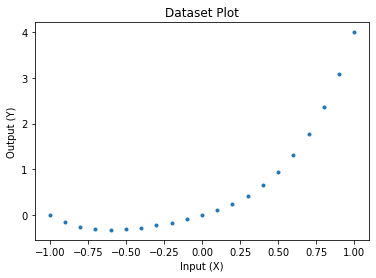

In [4]:
plt.figure()
plt.plot(X, y, '.')
plt.xlabel('Input (X)')
plt.ylabel('Output (Y)')
plt.title('Dataset Plot')
plt.show()

In [5]:
# define parameters
pop_size = 1000
gen_num = 50
cross_p = 0.7
mut_p = 0

### DEAP Framework
Adapted from https://deap.readthedocs.io/en/master/examples/gp_symbreg.html.

In [6]:
import operator
import math
import random

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

In [7]:
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

In [8]:
pset = gp.PrimitiveSet("MAIN", 1)

pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(math.log1p, 1)
pset.addPrimitive(math.exp, 1)
pset.addPrimitive(math.sin, 1)
pset.addPrimitive(math.cos, 1)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))
pset.renameArguments(ARG0='x')

In [9]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [10]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [11]:
def evalSymbReg(individual, points):
    '''function to evaluate the symbolic regression'''
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    
    # Evaluate the mean squared error between the expression
    # and the real function : x**4 + x**3 + x**2 + x
    
#     sqerrors = ((func(x) - x**4 - x**3 - x**2 - x)**2 for x in points)
#     return math.fsum(sqerrors) / len(points)

#     est_y = np.array([func(x) for x,_ in points])
#     y = np.array([y for _,y in points])

    errors = (abs(func(x) - y) for x,y in points)
    mae = math.fsum(errors)
    return mae,

In [12]:
# toolbox.register("evaluate", evalSymbReg, points=[x/10. for x in range(-10,11)])
toolbox.register("evaluate", evalSymbReg, points=data)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

In [13]:
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [14]:
random.seed(318)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

pop = toolbox.population(n=pop_size)
hof = tools.HallOfFame(1)
# pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 40, stats=mstats,
#                                    halloffame=hof, verbose=True)
pop, log = algorithms.eaSimple(population=pop, toolbox=toolbox, 
                               cxpb=cross_p, mutpb=mut_p, ngen=gen_num, 
                               stats=mstats, halloffame=hof, verbose=True)

   	      	                    fitness                     	                      size                     
   	      	------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max  	min	nevals	std     	avg  	gen	max	min	nevals	std    
0  	1000  	0.01705	0  	17.05	0  	1000  	0.538899	3.464	0  	7  	2  	1000  	1.45626
1  	718   	0      	1  	0    	0  	718   	0       	3.4  	1  	9  	2  	718   	1.39642
2  	682   	0      	2  	0    	0  	682   	0       	3.426	2  	10 	2  	682   	1.49282
3  	720   	0      	3  	0    	0  	720   	0       	3.406	3  	10 	2  	720   	1.49036
4  	686   	0      	4  	0    	0  	686   	0       	3.322	4  	11 	2  	686   	1.4298 
5  	714   	0      	5  	0    	0  	714   	0       	3.364	5  	11 	2  	714   	1.47292
6  	672   	0      	6  	0    	0  	672   	0       	3.414	6  	10 	2  	672   	1.51809
7  	700   	0      	7  	0    	0  	700   	0       	3.386	7  	10 	2  	700   	1.49164
8  	712   	0      	8  	0    	0  	712   	0     

In [15]:
fit_mins = log.chapters["fitness"].select("min")
fit_maxs = log.chapters["fitness"].select("max")
size_avgs = log.chapters["size"].select("avg")

In [16]:
print(fit_mins)
print(fit_maxs)
print(size_avgs)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[17.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[3.464, 3.4, 3.426, 3.406, 3.322, 3.364, 3.414, 3.386, 3.378, 3.385, 3.477, 3.453, 3.428, 3.409, 3.335, 3.36, 3.365, 3.363, 3.38, 3.437, 3.41, 3.394, 3.433, 3.457, 3.493, 3.48, 3.616, 3.661, 3.675, 3.74, 3.64, 3.665, 3.607, 3.578, 3.615, 3.605, 3.569, 3.58, 3.646, 3.537, 3.524, 3.57, 3.658, 3.609, 3.473, 3.459, 3.527, 3.513, 3.521, 3.532, 3.55]
